# Projet P7 OC Data Scientist: Implémentez un modèle de scoring 

# 1. Problématique

De nombreuses personnes ont du mal à obtenir des prêts en raison d'historiques de crédit insuffisants ou inexistants. Et, malheureusement, cette population est souvent la cible de prêteurs peu fiables.

Des entreprises comme Home Credit s'efforcent d'élargir l'inclusion financière de la population non bancarisée en offrant une expérience d'emprunt positive et sûre. Afin de s'assurer que cette population mal desservie ait une expérience de prêt positive, Home Credit utilise une variété de données alternatives (par exemple, les informations sur les télécommunications et les transactions, données comportementales) pour prédire les capacités de remboursement de leurs clients.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera ou non en mesure de rembourser un prêt. Il s'agit d'une tâche de classification supervisée standard :

- **Supervisé** : les étiquettes sont incluses dans les données d'apprentissage et l'objectif est d'entraîner un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques

- **Classification** : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)

Dans ce projet, les objectifs sont :
- la mise en oeuvre de routines d'exploration de données pour effectuer une analyse statistique et une visualisation.
- la mise en oeuvre de modèles de classification tels que Logistic Regression, Support Vector Machine (SVM), Random Forest, Gradient Boosting Machine (GBM), réseaux de neurones MLP Perceptron pour prédire si un demandeur pourra ou non rembourser un prêt.
- l'évaluation des modèles de classification (analyse de la précision, de la matrice de confusion, de la fonction de revenu personnalisé).
- le déploiement de la solution finale en tant qu'application Web sous forme de dashboard interactif (Streamlit) et API de prédiction (Flask).

# 2. Environnement et importation des librairies

In [98]:
# Librairies communes
from IPython.core.display import display, HTML
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import uniform
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly
import pickle
from yellowbrick.classifier import ConfusionMatrix
from collections import Counter
from scipy.stats import loguniform
from zipfile import ZipFile

# Librairies pour l'affichage
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Librairies diverses
import os
import gc
import pickle
import warnings
warnings.filterwarnings(action='ignore')
np.set_printoptions(suppress=True)
#pd.set_option('display.float_format', '{:.4f}'.format)

# For 100% jupyter notebook cell width
from IPython.core.display import display, HTML

# Librairies Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Librairie fonctions pour le projet
# Import du kernel Kaggle pour la préparation ded données
# Ancien kernel Kaggle
from p7_preprocess_data_eda_kernel_kaggle import *

# Nouveau kernel Kaggle
from p7_data_preparation_kernel_kaggle import *
from p7_eda_kernel_kaggle import *

# Fonctions pour le projet P7
from p7_functions import *

# Pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)
print("Version librairie imblearn: " + imblearn.__version__)

Version librairie pandas: 1.1.3
Version librairie numpy: 1.19.2
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0
Version librairie imblearn: 0.8.1


# 3. Fonctions

In [2]:
# Affichage des informations sur un dataset
def display_dataset_general_info(df_in, df_in_desc, info_suppl, id_df_in_merge_pk,
                                 id_df_in_merge_fk, df_in_application_train, df_in_application_test):
    print('Dimensions du dataset ' + df_in_desc +  ' est: ' + str(df_in.shape))
    print('-'*100)
    if info_suppl != None:
        print('Nombre d\'identifiants uniques ' + id_df_in_merge_pk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_pk].unique())))
        print('Nombre d\'identifiants clés étrangères ' + id_df_in_merge_fk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_fk].unique())))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_train et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_train[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_test et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_test[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('-'*100)
        
    print('Nombre de valeurs dupliquées dans ' +  df_in_desc + ': ' +  str(df_in.shape[0] - df_in.duplicated().shape[0]))
    print('-'*100)
    display(df_in.head())

In [50]:
# Fonction pour supprimer les colonnes d'un dataset 35 % ou plus de valeurs NaN
def drop_column_perc_nan(df_in, perc_nan):
    mod_df_in = df_in.copy()
    min_count =  int(((100-perc_nan)/100)*mod_df_in.shape[0] + 1)
    mod_df_in.dropna( axis=1, thresh=min_count, inplace=True)
    
    return mod_df_in

In [65]:
# Fonction pour standardisation des données du dataset
def std_dataset(df_in, method_std):
    df_in_std = pd.DataFrame(method_std.fit_transform(df_in), columns = df_in.columns)
    
    return df_in_std

In [5]:
# Fonction pour optimiser valeur k de KNN
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        print("k: " + str(k))
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        print(errors)
        
    return errors

In [6]:
# Fonction pour imputation KNN
def imputation_nan_knn(df_in, k):
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(df_in)
    df_imputed = pd.DataFrame(imputed, columns=df.columns)
    
    return df_imputed

In [7]:
# Fonction pour modelisation simple baseline
def model_baseline(model, model_name, X_train, y_train, X_test, y_test, 
                   df_save_metrics, cost_function_flag, tnr, tpc, fnc):
    # Entraînement du modèle sur le dataset train
    model.fit(X_train, y_train)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    if cost_function_flag != None:
        # Calcul de la fonction de coût personnalisée
        ccf, ocf = eval_custom_metric(cm, tnr, tpc, fnc)
    
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, "N/A", 
                                      "N/A", accuracy, auc,
                                      ccf, ocf, round(ccf/ocf,4), 
                                      metrics_by_class)
    else:
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, "N/A", 
                                      "N/A", accuracy, auc,
                                      "N/A", "N/A", "N/A", 
                                      metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results      

In [8]:
# Fonction pour affichage matrice de confusion
def display_matrix_confusion(confusion_matrix):
    
    labels = ['True Neg','False Pos','False Neg','True Pos'] 
    categories = ['0 - Non Defaulter', '1 - Defaulter'] 
    make_confusion_matrix(confusion_matrix, 
                      group_names=labels, 
                      categories=categories, 
                      cmap='Blues',
                      cbar=False,
                      sum_stats=False,
                      figsize=(4,4))
    
    return None

In [9]:
# Fonction pour l'enregistrement des résultats des métriques des classifieurs
def save_results_metrics(df_in, model, method_imb, optim_param, acc, 
                         auc, cost_function, optimum_cost_function, 
                         ratio_custom_optim_cost, 
                         metrics_class):
    # Tableau vide
    if df_in.shape[0] == 0:
        df_in.loc[0]=[model, method_imb, optim_param, acc,
                      auc, 
                      cost_function, optimum_cost_function, 
                      ratio_custom_optim_cost, 
                      metrics_class[0][0], metrics_class[0][1],
                      metrics_class[1][0], metrics_class[1][1],
                      metrics_class[2][0], metrics_class[2][1]]
        
    # Tableau non vide
    else:    
        df_in.loc[df_in.shape[0]]=[model, method_imb, optim_param, acc, 
                                   auc, 
                                   cost_function, optimum_cost_function,
                                   ratio_custom_optim_cost,
                                   metrics_class[0][0], metrics_class[0][1],
                                   metrics_class[1][0], metrics_class[1][1],
                                   metrics_class[2][0], metrics_class[2][1]]
        
    return df_in

In [10]:
# Fonction pour calculer métrique personnalisée - fonction de coût
def eval_custom_metric(confusion_matrix, tnr, tpc, fnc):
    tn = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    fn = confusion_matrix[1][0]
    tp = confusion_matrix[1][1]
    
    # Fonction de coût / revenu net
    revenue_net = tn*tnr - (fp*tnr) - (fn*fnc) - (tp*tpc)
    
    # Fonction de coût / revenu net idéale 
    # avec des prédictions de classes sans erreur
    
    revenue_net_optim = (tn+fp)*tnr - (tp+fn)*tpc
    
    return revenue_net, revenue_net_optim

In [11]:
# Fonction pour modelisation classifier baseline avec LogisticRegression
# Détermination de la méthode de traitement de déséquilibrage des classes
def eval_imbalance_class_method(over_sample, under_sample, class_weight,
                                X_train, y_train, X_test, y_test, df_save_metrics,
                                tnr, tpc, fnc, method_imb_name):
    
    # Nombre individus par classe sur y_train
    print("Nombre individus par classe sur y_train:")
    print(Counter(y_train))
    
    # Instanciation du modèle LogisticRegression
    model = LogisticRegression()
    
    # Détermination des étapes du pipeline imblearn
    if over_sample == None and under_sample == None and class_weight == None:
        print("Il faut passer un méthode over ou undersempling ou class weight")
        return None
    
    elif (over_sample != None and under_sample == None):
        print("Méthode de sur-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', over_sample)]
            
    elif (over_sample == None and under_sample != None):
        print("Méthode de sous-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', under_sample)]
            
    elif over_sample != None and under_sample != None:
        print("Pipeline over/undersampling: " + method_imb_name)
        # Pipeline imblearn
        steps = [('o', over_sample), ('u', under_sample)]
        
    else:
        print("Cas non géré")
        return None
    
    pipeline = Pipeline(steps=steps)
    
    # Rééchantillonnage des classes déséquilibrées
    X_train_imb, y_train_imb = pipeline.fit_resample(X_train, y_train)
        
    # Nombre individus par classe sur y_train_imb
    print("Nombre individus par classe sur y_train_imb après rééquilibrage des classes:")
    print(Counter(y_train_imb))

    # Entraînement du modèle sur le dataset train
    model.fit(X_train_imb, y_train_imb)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Calcul de la fonction de coût personnalisée
    ccf, ocf = eval_custom_metric(cm, tnr, tpc, fnc)
    
    # Enregistrement des résultats des métriques
    df_results = save_results_metrics(df_save_metrics, "LogisticRegression",
                                      method_imb_name, "N/A",
                                      accuracy, auc,
                                      ccf, ocf, round(ccf/ocf,4), metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results

In [12]:
def optim_hyperparam_predict_model(X_train, X_test, y_train, y_test, model, 
                                   param_grid, model_txt, nb_fold, df_save_metrics,
                                   tnr, tpc, fnc):
    
    # Pipeline imblearn
    over_sample = RandomOverSampler(sampling_strategy='auto')
    under_sample = RandomUnderSampler(sampling_strategy='auto')
    
    pipeline = Pipeline(steps=[('o', over_sample), ('u', under_sample), ('class', model)])

    print('Optimisation des hyper-paramètres pour le modèle ' + model_txt)
    print('---------------------------------------------------------------------------------')
    print('')
    
    model_grid = GridSearchCV(pipeline, 
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv=nb_fold,
                      verbose=1,
                      n_jobs=-1,       
                     )
    
    # Entraînement du modèle
    model_grid.fit(X_train, y_train)
    
    print("best score: ", model_grid.best_score_)
    print("best param: ", model_grid.best_params_)

    return None

In [13]:
# Fonction pour la prédiction des valeurs cible
def predict_model(X_train, y_train, X_test, y_test, model, model_txt, hyph_id, fic_hyperparam, target, log):
    
    # Chargement du fichier des hyper-paramètres
    loaded_hyp_param = joblib.load(fic_hyperparam)
    print('-----------------------------------------------------------------------------')
    print('Entraînement du modèle sur les hyper-paramètres optimisés: ' + model_txt)
    print('-----------------------------------------------------------------------------')
    print('Chargement du fichier des hyper-paramètres: ' + fic_hyperparam) 
    print('Hyper-paramètres optimisés: ' + str(loaded_hyp_param))
    
    # Entraînement du modèle
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    model.fit(X_train,y_train.values.ravel())
   
    # Prédictions sur le train et test set
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)  

    
    # Détermination du coefficient de détermination R²
    r2_test = np.round(r2_score(y_test, y_pred),2)
    r2_train = np.round(r2_score(y_train, y_pred_train),2)
    
    # si échelle logarithmique, passage à la fonction inverse (exp)
    if log == 'O':
        y_train = passage_log(np.array(y_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)
        y_test =  passage_log(np.array(y_test).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred = passage_log(np.array(y_pred).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred_train = passage_log(np.array(y_pred_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)

    # Détermination de la RMSE
    rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)
    
    # Détermination de la MAPE
    mape_test = np.round(mean_absolute_percentage_error(y_test, y_pred),2)
    mape_train = np.round(mean_absolute_percentage_error(y_train, y_pred_train),2)

    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données train') 
    print('----------------------------------------------------------------------------------------')
    print("Train R2: ", r2_train)
    print("Train RMSE: ", rmse_train)
    print("Train MAPE: ", mape_train)
    print('')
     
    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données test') 
    print('----------------------------------------------------------------------------------------')       
    print("Test R2: ", r2_test)
    print("Test RMSE: ", rmse_test)
    print("Test MAPE: ", mape_test)
    print('')    
    
    # Création du tableau de synthèse des erreurs de prédiction - train set
    df_results_error_train = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_train.index)
    
    # Création du tableau de synthèse des erreurs de prédiction - test set
    df_results_error_test = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_test.index)
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - train set
    df_results_perf_train = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - test set
    df_results_perf_test = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Remplissage du tableau des erreurs de prédiction pour le train/test
    df_results_error_train['Modeles'] = model_txt
    df_results_error_test['Modeles'] = model_txt
    df_results_error_train['Hypothese_id'] = hyph_id
    df_results_error_test['Hypothese_id'] = hyph_id
    df_results_error_train['Target'] = target
    df_results_error_test['Target'] = target
    df_results_error_train['Dataset'] = 'Train'
    df_results_error_test['Dataset'] = 'Test'
    df_results_error_train['y'] = y_train
    df_results_error_test['y'] = y_test
    df_results_error_train['y_pred'] = y_pred_train
    df_results_error_test['y_pred'] = y_pred
    df_results_error_train['abs(y-y_pred)'] = abs(df_results_error_train['y']-df_results_error_train['y_pred'])
    df_results_error_test['abs(y-y_pred)'] = abs(df_results_error_test['y']-df_results_error_test['y_pred'])
    df_results_error_train['%error'] = round(df_results_error_train['abs(y-y_pred)']/df_results_error_train['y']*100,2)
    df_results_error_test['%error'] = round(df_results_error_test['abs(y-y_pred)']/df_results_error_test['y']*100,2)
    
    # Remplissage du tableau des métriques de performance pour le train
    df_results_perf_train = df_results_perf_train.append(dict(zip(df_results_perf_train.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Train', 
                                                                   r2_train, 
                                                                   rmse_train, 
                                                                   mape_train])),ignore_index=True)
    
    # Remplissage du tableau des métriques de performance pour le test
    df_results_perf_test = df_results_perf_test.append(dict(zip(df_results_perf_test.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Test', 
                                                                   r2_test, 
                                                                   rmse_test, 
                                                                   mape_test])),ignore_index=True)
                
    #return df_results_error, df_results_perf
    return (df_results_error_train, df_results_error_test, df_results_perf_train, df_results_perf_test) 

# 4. Chargement et description des données

Les données Home Credit sont disponibles sur Kaggle à l'adresse suivante: [Données Home Credit](https://www.kaggle.com/c/home-credit-default-risk/data)

Le jeu de données Home Credit contient 7 tables, plus une table des descriptions des différentes variables.

- **application_{train|test}.csv**:

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).Ce sont données statiques pour toutes les applications. 

Une ligne représente un prêt dans l'échantillon de données, identifié par la variable "SK_ID_CURR".

La variable "TARGET" contient, soit la valeur 0 (le prêt a été remboursé à temps), soit la valeur 1 (le prêt n'a pas été remboursé à temps).


- **bureau.csv**:

Cela correspond à tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans  l'échantillon).

Pour chaque prêt de l'échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.


- **bureau_balance.csv**:

Cela correspond aux soldes mensuels des crédits précédents dans Credit Bureau.

Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a contient des lignes correspondant à X prêts dans l'échantillon multipliés par Y crédits précédents relatifs à Z mois où nous avons un historique observable pour les crédits précédents.


- **POS_CASH_balance.csv**:

Cela correspond aux instantanés du solde mensuel des précédents POS (points de vente) et des prêts en espèces que le demandeur avait avec Home Credit.

Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de l'échantillon - c'est-à-dire que le tableau contient des lignes correspondant à X prêts dans l'échantillon multipliés par le nombre Y de crédits précédents relatifs à Z mois pour lesquelles nous avons un historique observable pour les crédits précédents.


- **credit_card_balance.csv**:

Cela correspond aux instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.

Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de l'échantillon - c'est-à-dire que le tableau contient des lignes correspondant à X prêts dans l'échantillon multipliés par le nombre Y de cartes de crédit précédentes relatives à Z mois où nous avons un historique observable pour les lignes de carte de crédit précédentes.


- **previous_application.csv**:

Cela correspond à toutes les demandes antérieures de crédit des clients qui ont des crédits dans notre échantillon.

Il y a une ligne pour chaque demande précédente liée aux prêts dans l'échantillon de données. Chaque prêt en cours dans l'application ("application_train/test") peut avoir plusieurs des demandes/prêts antérieur(e)s. Chaque demande de prêt antérieure est identifiée par la variable "SK_ID_PREV". 

- **installments_payments.csv**:

Cela correspond à l'historique de remboursement des crédits précédemment décaissés chez Home Credit relatifs aux crédits de l'échantillon.

Il y a une ligne pour chaque paiement effectué plus une ligne pour chaque échéance de paiement manquée.

Une ligne équivaut à un versement d'une échéance ou une échéance correspondant à un versement d'un précédent crédit Home Credit lié aux crédits de l'échantillon.

- **HomeCredit_columns_description.csv**:

Ce fichier contient les descriptions des colonnes des différents fichiers de données.

## 4.1 Modèle de données

![title](home_credit_model.png)

## 4.2 Chargement des tables

In [3]:
# Chargement de l'ensemble des tables - appel de la fonction load_tables
application_train, application_test, bureau, bureau_balance,\
cc_balance, installments_payments, POS_CASH_balance,\
previous_application = load_all_tables(directory_path='./Input/')

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Done.
Time Taken to load 8 tables = 0:00:46.841815


## 4.3 Dataset "application_train"

In [15]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(application_train, "application_train",  None, None,
                                 None, None, None)

Dimensions du dataset application_train est: (307511, 122)
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans application_train: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,nan,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,nan,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,nan,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.5559,0.

Le dataset application_train contient 307 511 lignes et 122 variables. 
Ces variables décrivent des informations statistiques sur l'emprunteur:
- Age 
- Revenus
- Type de prêt
- etc.

L'identifiant de ce dataset est la colonne "SK_ID_CURR".

La colonne "TARGET" représente la status pour la défaillance de crédit: 0 pour les emprunteurs non défaillants, 
1 pour les emprunteurs défaillances.

### 4.3.1 Panorama des colonnes avec valeurs NaN

In [16]:
application_train_nan = nan_df_create(application_train)
application_train_nan

,column,percent
76,COMMONAREA_MEDI,69.8723
48,COMMONAREA_AVG,69.8723
62,COMMONAREA_MODE,69.8723
70,NONLIVINGAPARTMENTS_MODE,69.4330
56,NONLIVINGAPARTMENTS_AVG,69.4330
84,NONLIVINGAPARTMENTS_MEDI,69.4330
86,FONDKAPREMONT_MODE,68.3862
68,LIVINGAPARTMENTS_MODE,68.3550
54,LIVINGAPARTMENTS_AVG,68.3550
82,LIVINGAPARTMENTS_MEDI,68.3550


Number of columns having NaN values: 67 columns


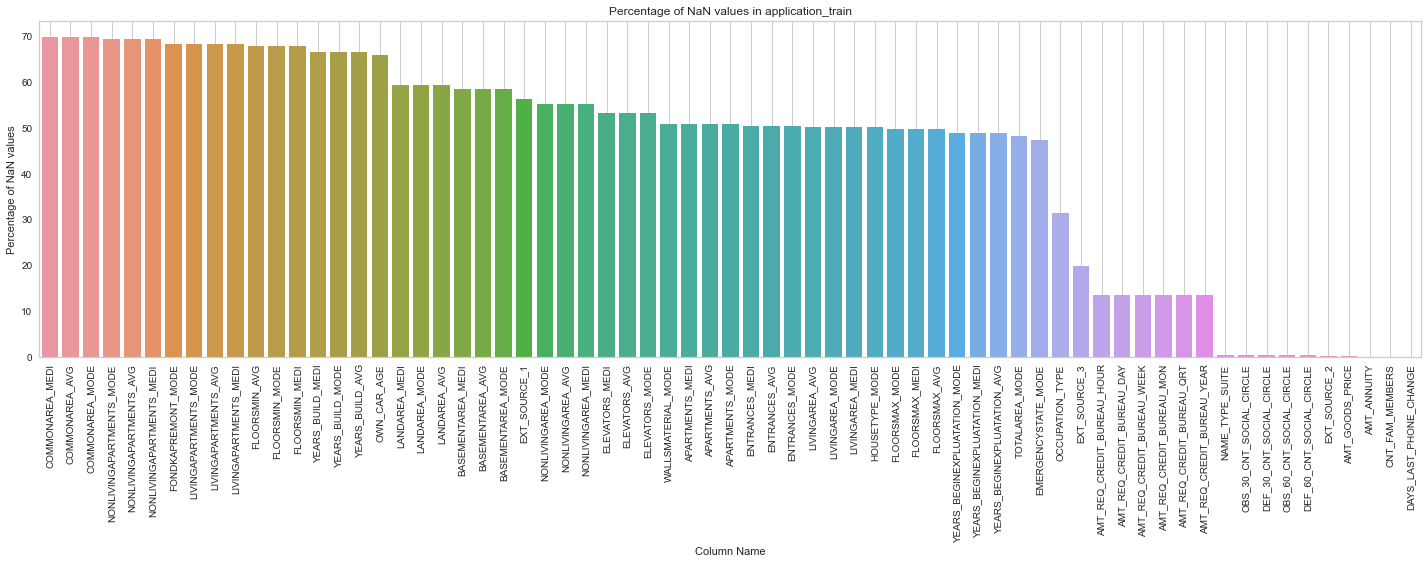

In [17]:
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

- On peut voir sur le graphique ci-dessus qu'il y a 67 colonnes sur 122 caractéristiques qui contiennent des valeurs NaN. S'il n'y avait qu'une ou deux colonnes qui avaient des valeurs NaN, nous aurions pu nous en tirer en éliminant simplement ces colonnes, mais pour un si grand nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très élevée.

- Nous voyons que certaines colonnes comme relatives à "COMMONAREA", "NONLIVINAPARTMENT", etc. ont près de 70% de valeurs manquantes. Nous devrons trouver des techniques pour gérer ces nombreuses valeurs manquantes et voir ce qui fonctionnerait le mieux pour nos données.

- Une autre chose à noter ici est que la plupart des colonnes qui ont plus de 50% de valeurs manquantes sont liées aux statistiques des appartements de l'emprunteur. Il est très probable que ces valeurs n'aient pas été enregistrées lors de la saisie des données et pourraient être facultatives.

### 4.3.2 Distribution de la variable "TARGET"

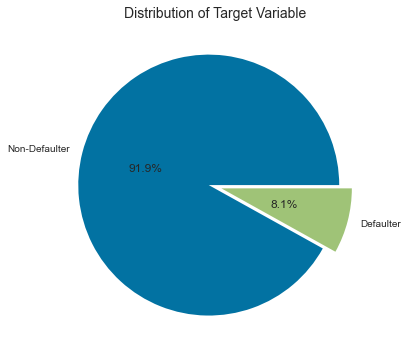

In [18]:
# Affichage de la distribution de la variable "TARGET"
target_distribution = application_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=target_distribution, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Distribution of Target Variable", fontsize=14);

- De la distribution de la variable cible, une chose que nous pouvons rapidement remarquer est le déséquilibre des données. Il n'y a que 8, 8,1 % du total des prêts qui ont effectivement été en défaut. Cela signifie que les défaillants sont la classe minoritaire.

- En revanche, il y a 91,9% de prêts qui n'ont pas été en Défaillance. Ainsi, les Non-Defaulters seront notre classe majoritaire.

- Les défaillants ont reçu une variable cible de 1 et les non-défauts ont reçu une variable cible 0.

- Pour les jeux de données déséquilibrés, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles à certains algorithmes, qui sont sensibles aux déséquilibres.

- Similaire est le cas avec les mesures de performance. Pour un tel ensemble de données, la précision n'est généralement pas la bonne métrique car la précision serait généralement biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres métriques telles que le score ROC-AUC, la perte de log, le score F1, la matrice de confusion pour une meilleure évaluation du modèle.

- Une autre chose importante à noter ici est qu'il y a très peu de gens qui font réellement défaut, et ils ont tendance à montrer une sorte de comportement différent. Ainsi, dans de tels cas de fraude, de défaut et de détection d'anomalies, nous devons également nous concentrer sur les valeurs aberrantes, et nous ne pouvons pas les supprimer, car elles pourraient être le facteur de différenciation entre défaillant et non défaillant.

### 4.3.3 Analyse multivariée - matrice phi-k pour variables catégorielles

----------------------------------------------------------------------------------------------------


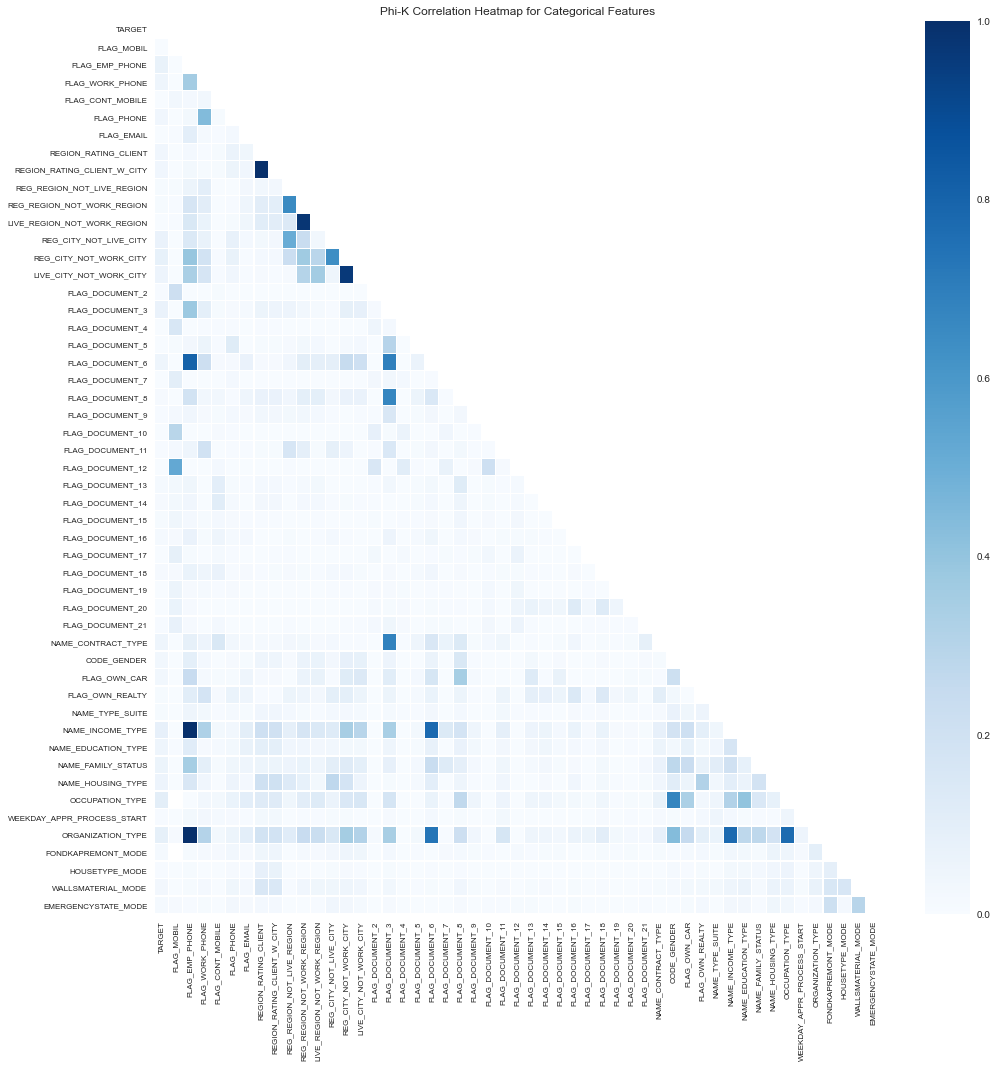

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.1028
45,ORGANIZATION_TYPE,0.0892
39,NAME_INCOME_TYPE,0.0848
12,REG_CITY_NOT_WORK_CITY,0.0799
1,FLAG_EMP_PHONE,0.0721
11,REG_CITY_NOT_LIVE_CITY,0.0696
15,FLAG_DOCUMENT_3,0.0695
41,NAME_FAMILY_STATUS,0.0560
42,NAME_HOUSING_TYPE,0.0511
13,LIVE_CITY_NOT_WORK_CITY,0.0510


----------------------------------------------------------------------------------------------------


In [19]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)

À partir de la carte thermique ci-dessus de la corrélation Phi-K, nous voyons que la plupart des caractéristiques catégorielles ne sont pas corrélées les unes aux autres, mais certaines d'entre elles présentent une forte corrélation.

Certaines des paires de catégories hautement corrélées sont :
RÉGION_RATING_CLIENT_W_CITY et REGION_RATING_CLIENT - Ceci est compréhensible car ils raconteraient plus ou moins une histoire similaire.
LIVE_REGION_NOT_WORK_REGION et REG_REGION_NOT_WORK_REGION
NOM_REVENU_TYPE, ORGANISATION_TYPE et DRAPEAU_EMP_TÉLÉPHONE

Nous pouvons également voir une certaine corrélation entre le type d'organisation et le type de revenu d'un client. De même, nous voyons une corrélation entre le type d'occupation et le type d'organisation aussi.

Nous constatons que la catégorie OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY sont parmi les catégories les plus corrélées avec la CIBLE variable. Ceux-ci peuvent être importants dans la tâche de classification et nécessiteraient une EDA supplémentaire

### 4.3.4 Analyse multivariée - matrice de corrélations pour les variables numériques

----------------------------------------------------------------------------------------------------


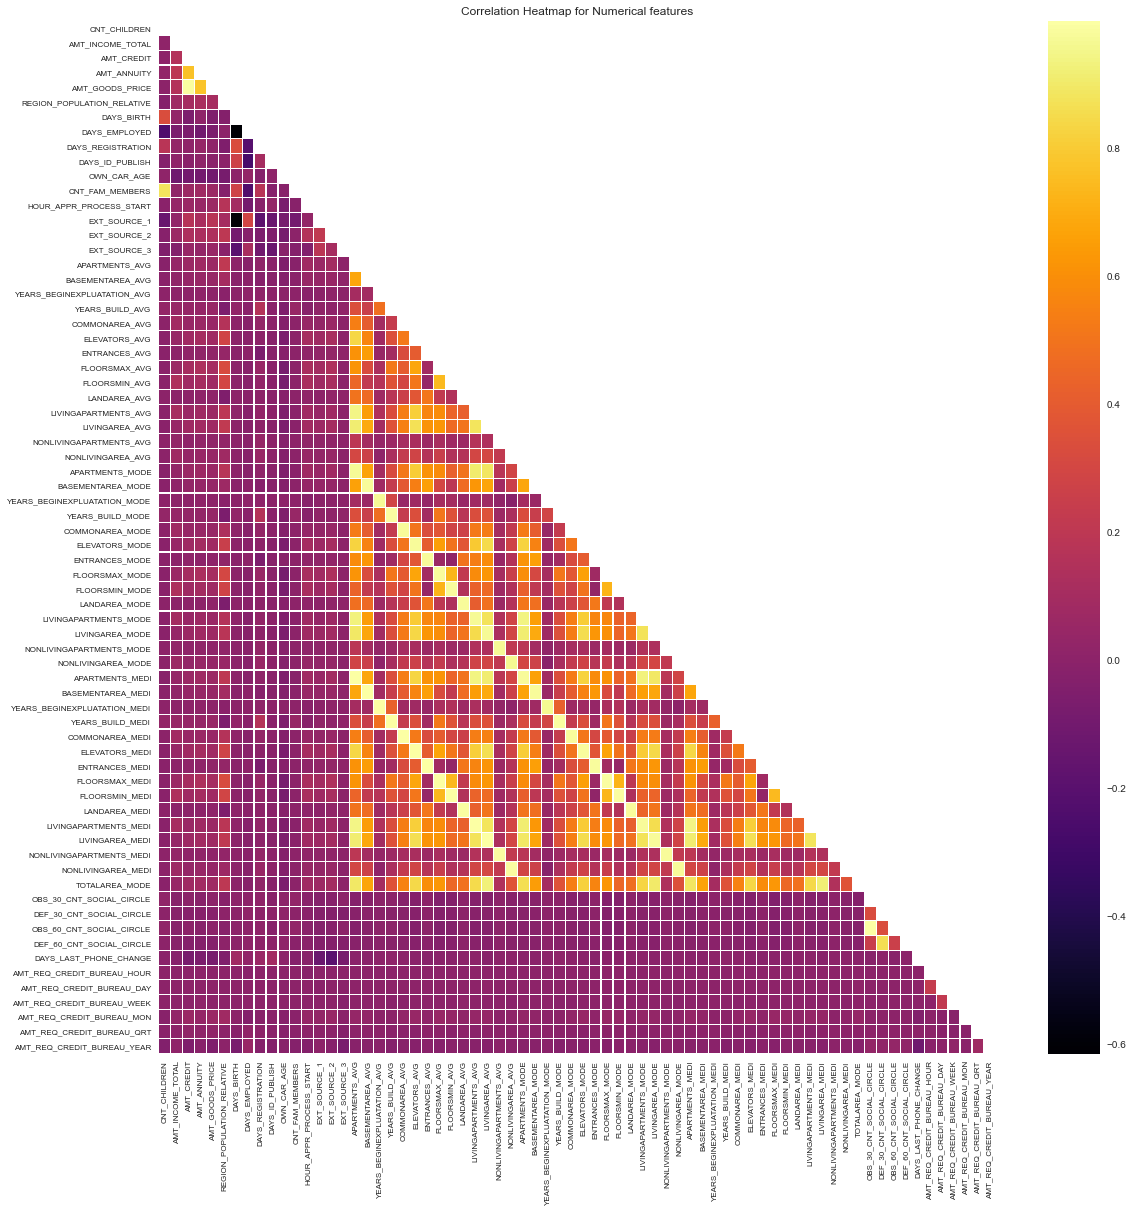

----------------------------------------------------------------------------------------------------


In [20]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [21]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.2477
13,EXT_SOURCE_1,0.2178
14,EXT_SOURCE_2,0.2140
6,DAYS_BIRTH,0.1024
63,DAYS_LAST_PHONE_CHANGE,0.0732
7,DAYS_EMPLOYED,0.0721
9,DAYS_ID_PUBLISH,0.0678
4,AMT_GOODS_PRICE,0.0591
23,FLOORSMAX_AVG,0.0588
51,FLOORSMAX_MEDI,0.0586


----------------------------------------------------------------------------------------------------


- La carte thermique montre bien la valeur ou le niveau de corrélation de chaque caractéristique particulière avec toutes les autres caractéristiques.

- On peut observer que la majeure partie de la carte thermique contient une couleur violette, ce qui indique une très petite valeur de corrélation. Cela implique que la plupart des caractéristiques ne sont en effet pas corrélées aux autres.

- Cependant, nous pouvons voir des nuances contrastées au milieu de la carte thermique. Ces nuances représentent une valeur élevée de corrélation entre les caractéristiques. Ce sont les caractéristiques qui sont liées aux statistiques des appartements.
Si nous regardons les caractéristiques de l'application_train, nous pouvons clairement voir que les statistiques des appartements sont données en termes de moyenne, médiane et mode, on peut donc s'attendre à ce que la moyenne, la médiane et le mode soient corrélés avec chacun autre. Une autre chose à noter est que les caractéristiques d'une catégorie particulière, par exemple la moyenne, sont également corrélées avec d'autres caractéristiques moyennes, telles que le nombre d'ascenseurs, la superficie habitable, la superficie non habitable, la superficie du sous-sol, etc.

- Nous constatons également une forte corrélation entre AMT_GOODS_PRICE et AMT_CREDIT, entre DAYS_EMPLOYED et DAYS_BIRTH.

- Nous ne voudrions pas de fonctionnalités fortement corrélées car elles augmentent la complexité temporelle du modèle sans lui ajouter beaucoup de valeur. Par conséquent, nous supprimerions les caractéristiques inter-corrélées.

- Parmi toutes les fonctionnalités, nous voyons une forte corrélation pour les fonctionnalités EXT_SOURCE par rapport à la variable cible. Ceux-ci pourraient être importants pour notre tâche de classification.

## 4.4 Dataset "application_test"

In [22]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(application_test, "application_test",  None, None,
                                 None, None, None)

Dimensions du dataset application_test est: (48744, 121)
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans application_test: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0000,568800.0000,20560.5000,450000.0000,Unaccompanied,Working,Higher education,Married,House / apartment,0.0188,-19241,-2329,-5170.0000,-812,nan,1,1,0,1,0,1,NaN,2.0000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.7526,0.7897,0.1595,0.0660,0.0590,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0505,nan,nan,0.0672,0.0612,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0526,nan,nan,0.0666,0.0590,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0514,nan,nan,NaN,block of flats,0.0392,"Stone, brick",No,0.0000,0.0000,0.0000,0.0000,-1740.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,100005,Cash loans,M,N,Y,0,99000.0000,222768.0000,17370.0000,180000.0000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.0358,-18064,-4469,-9118.0000,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2.0000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.5650,0.2917,0.4330,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
2,100013,Cash loans,M,Y,Y,0,202500.0000,663264.0000,69777.0000,630000.0000,NaN,Working,Higher education,Married,House / apartment,0.0191,-20038,-4458,-2175.0000,-3503,5.0000,1,1,0,1,0,0,Drivers,2.0000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,nan,0.6998,0.6110,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.0000,0.0000,0.0000,0.0000,-856.0000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,1

Le dataset application_test contient 48 744 lignes et 121 variables. 

Les variables sont les mêmes que sur le dataset df_application_train, mais il n'y pas de colonne "TARGET", les valeurs de cette colonne doivent être prédites par des modèles de classification de Machine Learning.

L'identifiant de ce dataset est la colonne "SK_ID_CURR".

### 4.4.1 Panorama des colonnes avec valeurs NaN

In [23]:
application_test_nan = nan_df_create(application_test)
application_test_nan

,column,percent
47,COMMONAREA_AVG,68.7161
61,COMMONAREA_MODE,68.7161
75,COMMONAREA_MEDI,68.7161
55,NONLIVINGAPARTMENTS_AVG,68.4125
69,NONLIVINGAPARTMENTS_MODE,68.4125
83,NONLIVINGAPARTMENTS_MEDI,68.4125
85,FONDKAPREMONT_MODE,67.2842
53,LIVINGAPARTMENTS_AVG,67.2493
67,LIVINGAPARTMENTS_MODE,67.2493
81,LIVINGAPARTMENTS_MEDI,67.2493


Number of columns having NaN values: 64 columns


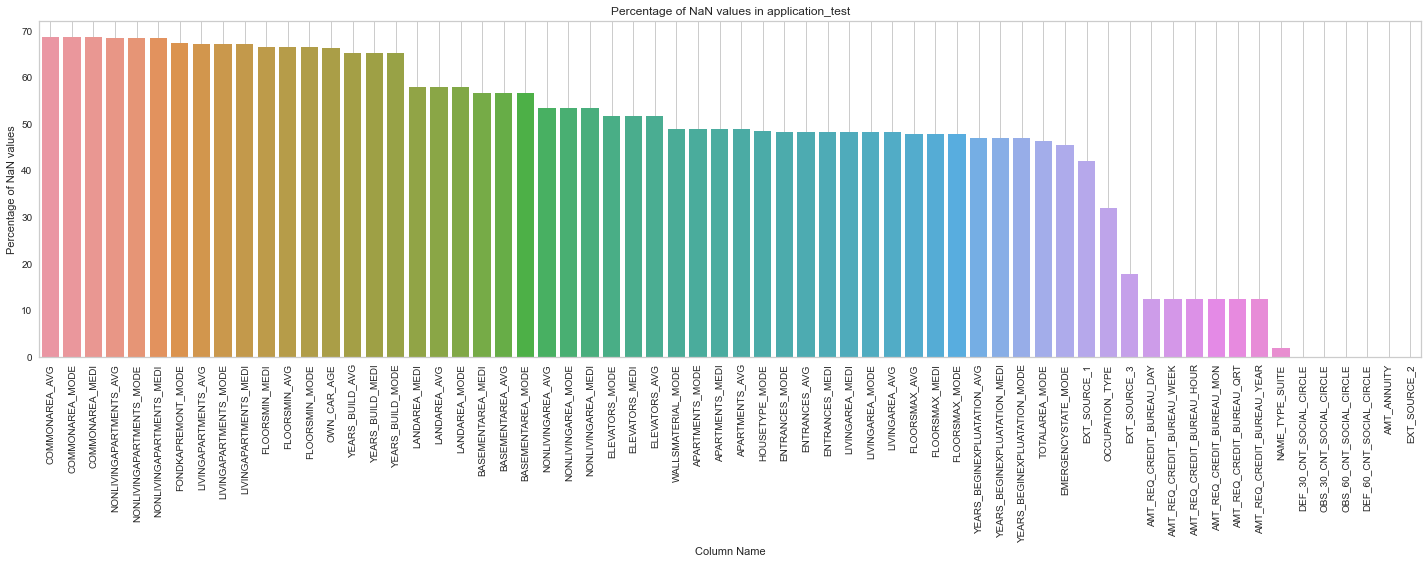

In [24]:
plot_nan_percent(nan_df_create(application_test), 'application_test', grid = True)

- Il y a un nombre très similaire de colonnes avec des valeurs NaN (64) comme avec application_train.

- Les pourcentages de valeurs NaN sont également assez similaires à ceux présents dans l'ensemble de données d'entraînement. Cela signifie que les ensembles d'entraînement et de test sont à peu près de distribution similaire.

## 4.5 Dataset "bureau"

In [25]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(bureau, "bureau", "O", "SK_ID_BUREAU","SK_ID_CURR",
                             application_train, application_test)

Dimensions du dataset bureau est: (1716428, 17)
----------------------------------------------------------------------------------------------------
Nombre d'identifiants uniques SK_ID_BUREAU dans bureau: 1716428
Nombre d'identifiants clés étrangères SK_ID_CURR dans bureau: 305811
Nombre de correspondances SK_ID_CURR entre dataset application_train et bureau: 263491
Nombre de correspondances SK_ID_CURR entre dataset application_test et bureau: 42320
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans bureau: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,nan,0,91323.0000,0.0000,nan,0.0000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.0000,nan,nan,0,225000.0000,171342.0000,nan,0.0000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.0000,nan,nan,0,464323.5000,nan,nan,0.0000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.0000,nan,nan,0.0000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.0000,nan,77674.5000,0,2700000.0000,nan,nan,0.0000,Consumer credit,-21,nan


### 4.5.1 Panorama des colonnes avec valeurs NaN

In [26]:
bureau_nan = nan_df_create(bureau)
bureau_nan

,column,percent
16,AMT_ANNUITY,71.4735
8,AMT_CREDIT_MAX_OVERDUE,65.5133
7,DAYS_ENDDATE_FACT,36.9170
12,AMT_CREDIT_SUM_LIMIT,34.4774
11,AMT_CREDIT_SUM_DEBT,15.0119
6,DAYS_CREDIT_ENDDATE,6.1496
10,AMT_CREDIT_SUM,0.0008
2,CREDIT_ACTIVE,0.0000
3,CREDIT_CURRENCY,0.0000
4,DAYS_CREDIT,0.0000


Number of columns having NaN values: 7 columns


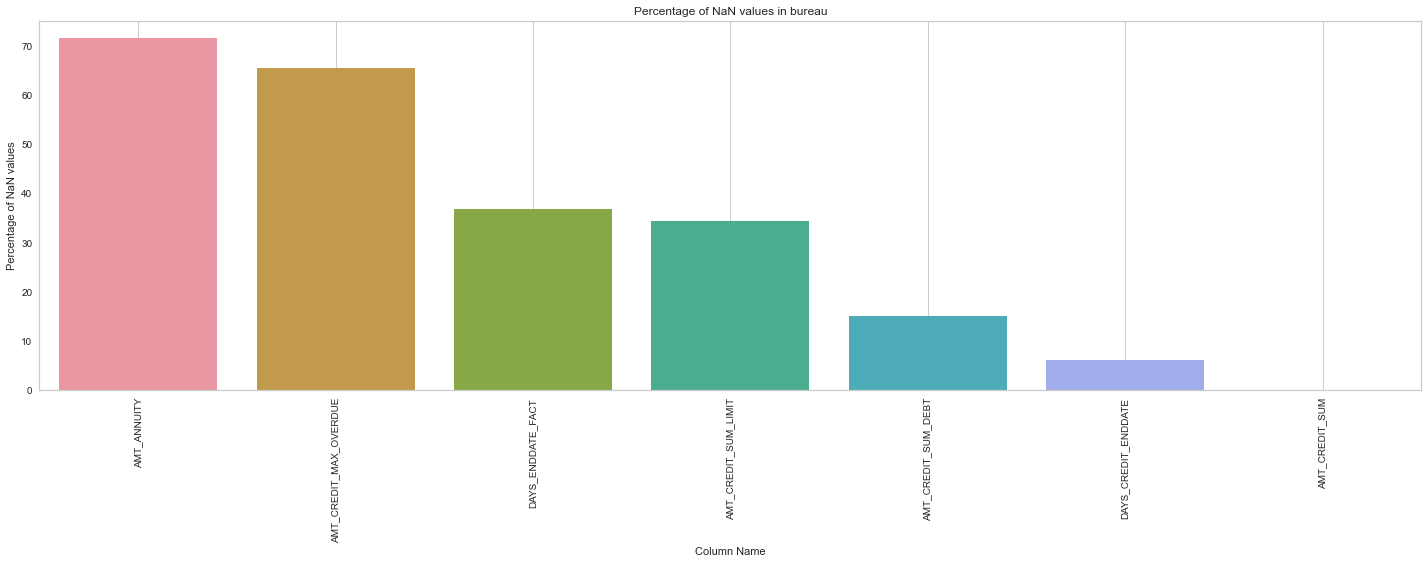

In [27]:
plot_nan_percent(nan_df_create(bureau), 'bureau', grid = True)

## 4.6 Dataset "bureau_balance"

In [28]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(bureau_balance, "bureau_balance", None, None, None,
                             None, None)

Dimensions du dataset bureau_balance est: (27299925, 3)
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans bureau_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


### 4.6.1 Panorama des colonnes avec valeurs NaN

In [29]:
bureau_balance_nan = nan_df_create(bureau_balance)
bureau_balance_nan

,column,percent
0,SK_ID_BUREAU,0.0000
1,MONTHS_BALANCE,0.0000
2,STATUS,0.0000


In [30]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance', grid = True)

The dataframe bureau_balance does not contain any NaN values.


## 4.7 Dataset "POS_CASH_balance"

In [31]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(POS_CASH_balance, "POS_CASH_balance", "O", "SK_ID_PREV","SK_ID_CURR",
                             application_train, application_test)

Dimensions du dataset POS_CASH_balance est: (10001358, 8)
----------------------------------------------------------------------------------------------------
Nombre d'identifiants uniques SK_ID_PREV dans POS_CASH_balance: 936325
Nombre d'identifiants clés étrangères SK_ID_CURR dans POS_CASH_balance: 337252
Nombre de correspondances SK_ID_CURR entre dataset application_train et POS_CASH_balance: 289444
Nombre de correspondances SK_ID_CURR entre dataset application_test et POS_CASH_balance: 47808
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0
3,1903291,269225,-35,48.0000,42.0000,Active,0,0
4,2341044,334279,-35,36.0000,35.0000,Active,0,0


### 4.7.1 Panorama des colonnes avec valeurs NaN

In [32]:
POS_CASH_balance_nan = nan_df_create(POS_CASH_balance)
POS_CASH_balance_nan

,column,percent
4,CNT_INSTALMENT_FUTURE,0.2608
3,CNT_INSTALMENT,0.2607
0,SK_ID_PREV,0.0000
1,SK_ID_CURR,0.0000
2,MONTHS_BALANCE,0.0000
5,NAME_CONTRACT_STATUS,0.0000
6,SK_DPD,0.0000
7,SK_DPD_DEF,0.0000


Number of columns having NaN values: 2 columns


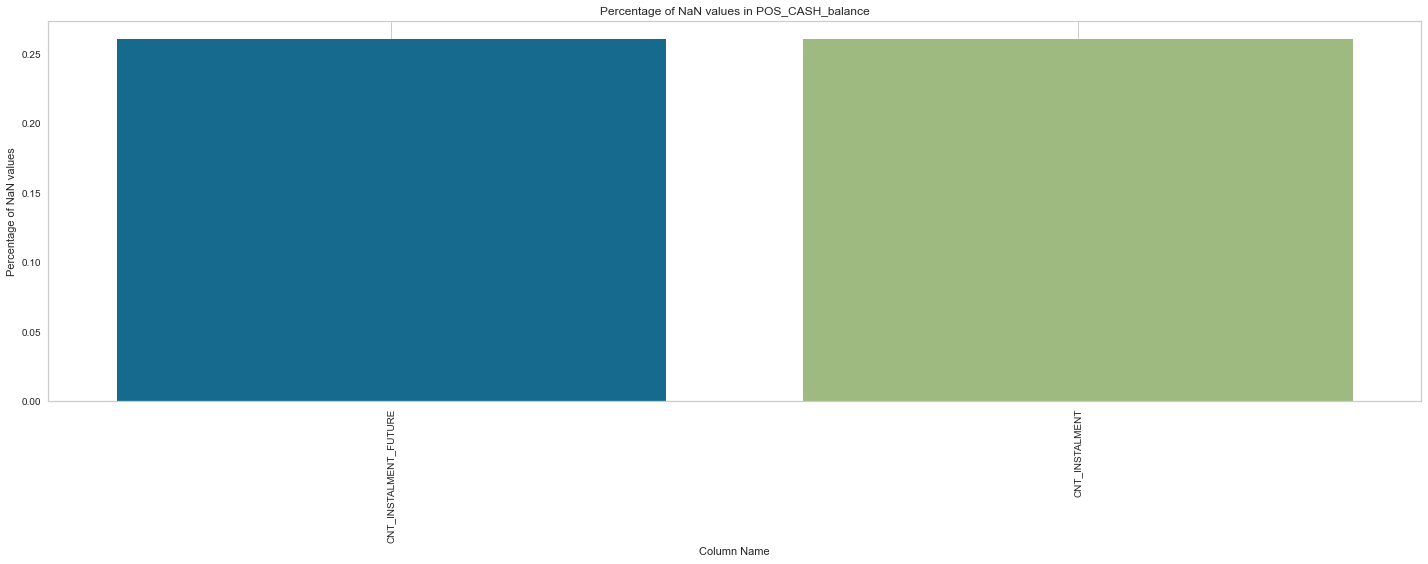

In [33]:
plot_nan_percent(nan_df_create(POS_CASH_balance), 'POS_CASH_balance', grid = True)

### 5.5.2 Analyse univariée

### 5.5.3 Analyse multivariée - matrice phi-k pour variables catégorielles

### 5.5.4 Analyse multivariée - matrice de corrélations pour les variables numériques

## 4.8 Dataset "credit_card_balance"

In [34]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(cc_balance, "cc_balance", "O", "SK_ID_PREV","SK_ID_CURR",
                             application_train, application_test)

Dimensions du dataset cc_balance est: (3840312, 23)
----------------------------------------------------------------------------------------------------
Nombre d'identifiants uniques SK_ID_PREV dans cc_balance: 104307
Nombre d'identifiants clés étrangères SK_ID_CURR dans cc_balance: 103558
Nombre de correspondances SK_ID_CURR entre dataset application_train et cc_balance: 86905
Nombre de correspondances SK_ID_CURR entre dataset application_test et cc_balance: 16653
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans cc_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,1800.0000,1800.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,Active,0,0
1,2582071,363914,-1,63975.5550,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,60175.0800,64875.5550,64875.5550,1.0000,1,0.0000,0.0000,69.0000,Active,0,0
2,1740877,371185,-7,31815.2250,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,26926.4250,31460.0850,31460.0850,0.0000,0,0.0000,0.0000,30.0000,Active,0,0
3,1389973,337855,-4,236572.1100,225000,2250.0000,2250.0000,0.0000,0.0000,11795.7600,11925.0000,11925.0000,224949.2850,233048.9700,233048.9700,1.0000,1,0.0000,0.0000,10.0000,Active,0,0
4,1891521,126868,-1,453919.4550,450000,0.0000,11547.0000,0.0000,11547.0000,22924.8900,27000.0000,27000.0000,443044.3950,453919.4550,453919.4550,0.0000,1,0.0000,1.0000,101.0000,Active,0,0


### 4.8.1 Panorama des colonnes avec valeurs NaN

In [35]:
cc_balance_nan = nan_df_create(cc_balance)
cc_balance_nan

,column,percent
10,AMT_PAYMENT_CURRENT,19.9981
5,AMT_DRAWINGS_ATM_CURRENT,19.5249
18,CNT_DRAWINGS_POS_CURRENT,19.5249
7,AMT_DRAWINGS_OTHER_CURRENT,19.5249
8,AMT_DRAWINGS_POS_CURRENT,19.5249
17,CNT_DRAWINGS_OTHER_CURRENT,19.5249
15,CNT_DRAWINGS_ATM_CURRENT,19.5249
19,CNT_INSTALMENT_MATURE_CUM,7.9482
9,AMT_INST_MIN_REGULARITY,7.9482
0,SK_ID_PREV,0.0000


Number of columns having NaN values: 9 columns


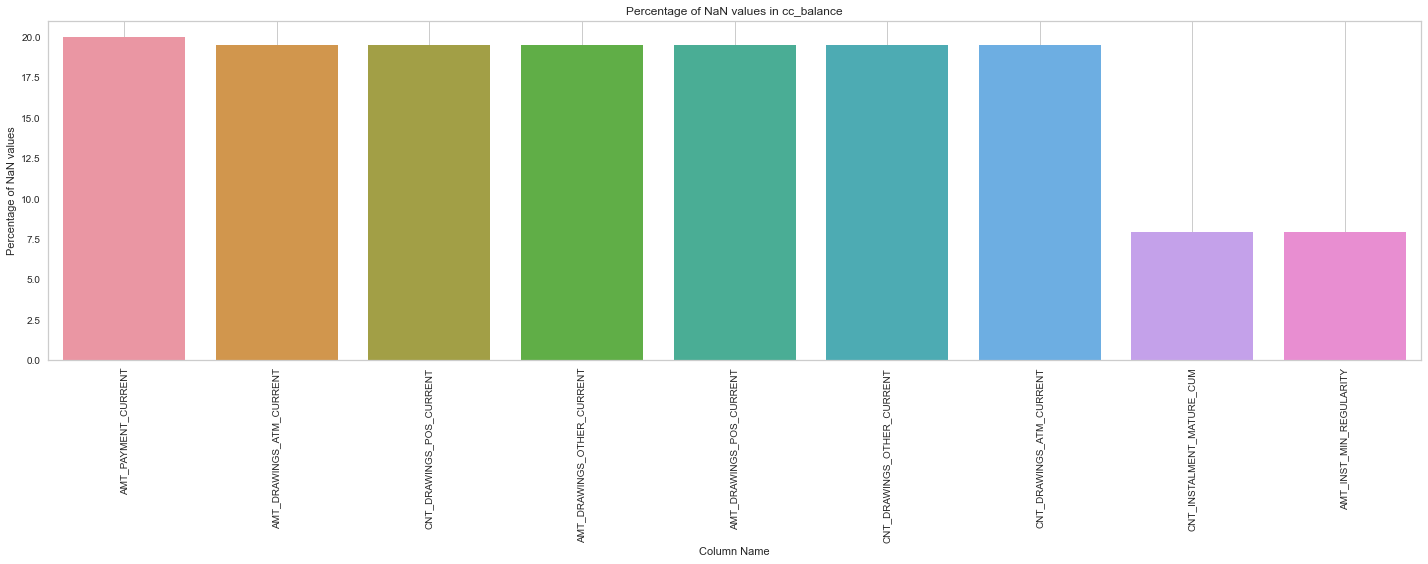

In [36]:
plot_nan_percent(nan_df_create(cc_balance), 'cc_balance', grid = True)

## 4.9 Dataset "previous_application"

In [37]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(previous_application, "previous_application", "O", "SK_ID_PREV","SK_ID_CURR",
                             application_train, application_test)

Dimensions du dataset previous_application est: (1670214, 37)
----------------------------------------------------------------------------------------------------
Nombre d'identifiants uniques SK_ID_PREV dans previous_application: 1670214
Nombre d'identifiants clés étrangères SK_ID_CURR dans previous_application: 338857
Nombre de correspondances SK_ID_CURR entre dataset application_train et previous_application: 291057
Nombre de correspondances SK_ID_CURR entre dataset application_test et previous_application: 47800
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans previous_application: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,1,0.0000,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6150,607500.0000,679671.0000,nan,607500.0000,THURSDAY,11,Y,1,nan,nan,nan,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7350,112500.0000,136444.5000,nan,112500.0000,TUESDAY,11,Y,1,nan,nan,nan,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,Cash loans,47041.3350,450000.0000,470790.0000,nan,450000.0000,MONDAY,7,Y,1,nan,nan,nan,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,middle,Cash X-Sell: middle,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3950,337500.0000,404055.0000,nan,337500.0000,THURSDAY,9,Y,1,nan,nan,nan,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0000,high,Cash Street: high,nan,nan,nan,nan,nan,nan


### 4.9.1 Panorama des colonnes avec valeurs NaN

In [38]:
previous_application_nan = nan_df_create(previous_application)
previous_application_nan

,column,percent
14,RATE_INTEREST_PRIVILEGED,99.6437
13,RATE_INTEREST_PRIMARY,99.6437
6,AMT_DOWN_PAYMENT,53.6365
12,RATE_DOWN_PAYMENT,53.6365
20,NAME_TYPE_SUITE,49.1198
36,NFLAG_INSURED_ON_APPROVAL,40.2981
35,DAYS_TERMINATION,40.2981
34,DAYS_LAST_DUE,40.2981
33,DAYS_LAST_DUE_1ST_VERSION,40.2981
32,DAYS_FIRST_DUE,40.2981


Number of columns having NaN values: 16 columns


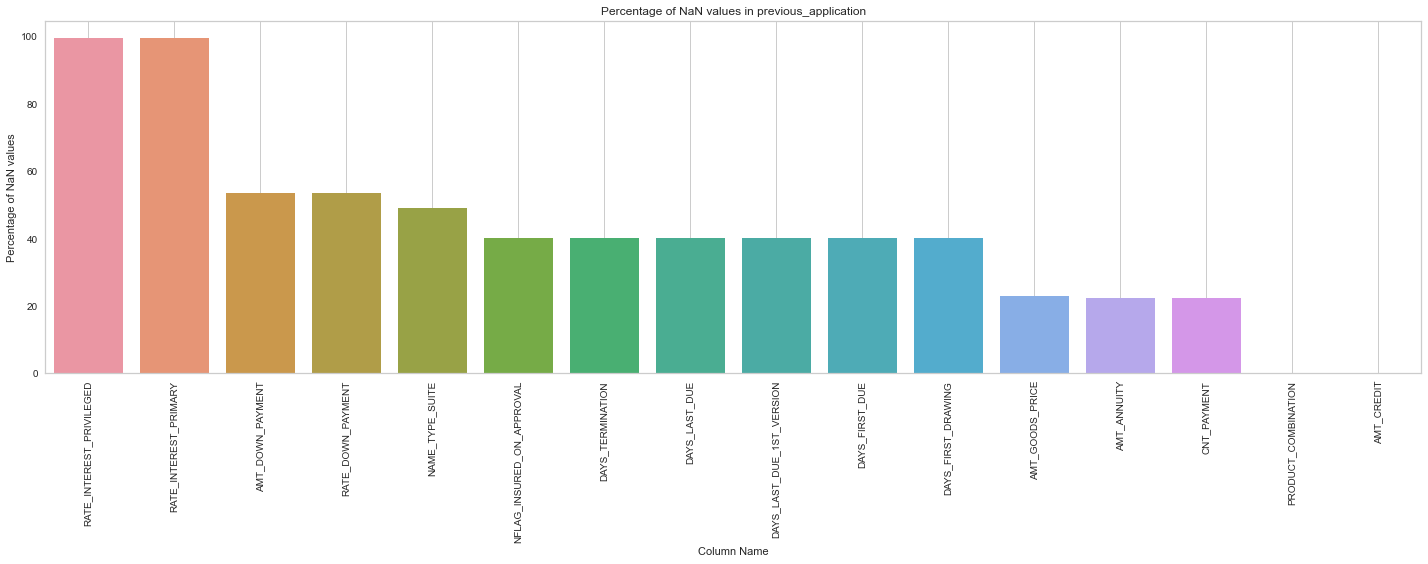

In [39]:
plot_nan_percent(nan_df_create(previous_application), 'previous_application', grid = True)

## 4.10 Dataset "installments_payments"

In [40]:
# Affichage des informations générales sur le dataset
display_dataset_general_info(installments_payments, "installments_payments", "O", "SK_ID_PREV","SK_ID_CURR",
                             application_train, application_test)

Dimensions du dataset installments_payments est: (13605401, 8)
----------------------------------------------------------------------------------------------------
Nombre d'identifiants uniques SK_ID_PREV dans installments_payments: 997752
Nombre d'identifiants clés étrangères SK_ID_CURR dans installments_payments: 339587
Nombre de correspondances SK_ID_CURR entre dataset application_train et installments_payments: 291643
Nombre de correspondances SK_ID_CURR entre dataset application_test et installments_payments: 47944
----------------------------------------------------------------------------------------------------
Nombre de valeurs dupliquées dans installments_payments: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1300,24350.1300
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850


### 4.10.1 Panorama des colonnes avec valeurs NaN

In [41]:
installments_payments_nan = nan_df_create(installments_payments)
installments_payments_nan

,column,percent
5,DAYS_ENTRY_PAYMENT,0.0214
7,AMT_PAYMENT,0.0214
0,SK_ID_PREV,0.0000
1,SK_ID_CURR,0.0000
2,NUM_INSTALMENT_VERSION,0.0000
3,NUM_INSTALMENT_NUMBER,0.0000
4,DAYS_INSTALMENT,0.0000
6,AMT_INSTALMENT,0.0000


Number of columns having NaN values: 2 columns


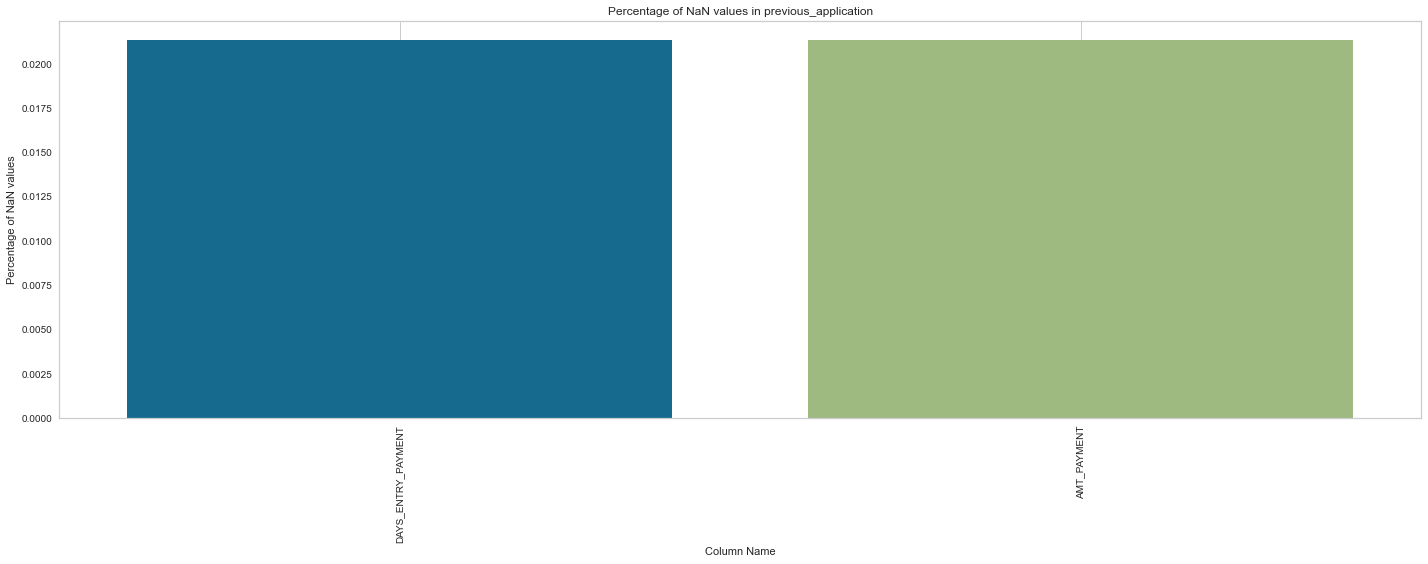

In [42]:
plot_nan_percent(nan_df_create(installments_payments), 'previous_application', grid = True)

# 5. Feature engineering / Data cleaning à partir d'un kernel Kaggle

Kernel kaggle utilisé: https://www.kaggle.com/ibrahimyildiz/home-credit-with-lgbm
Etapes du kernel Kaggle:

**Etapes de merge des 7 différents datasets**: 
- Merge des dataset "application_train" et "application_test",
- Création de nouvelles variables
- Agrégation
- OneHot encoding des variables catégorielles

**Etape pour afficher l'importance des variables**: 
- Affichage de l'importance de features avec lighGBM

## 5.1 Exécution du kernel kaggle

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 36s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 47s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 20s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796937	training's binary_logloss: 0.234847	valid_1's auc: 0.775923	valid_1's binary_logloss: 0.24683
[400]	training's auc: 0.819329	training's binary_logloss: 0.225295	valid_1's auc: 0.786496	valid_1's binary_logloss: 0.24275
[600]	training's auc: 0.834077	training's binary_logloss: 0.219246	valid_1's auc: 0.790546	valid_1

[400]	training's auc: 0.819665	training's binary_logloss: 0.225482	valid_1's auc: 0.781593	valid_1's binary_logloss: 0.241074
[600]	training's auc: 0.834472	training's binary_logloss: 0.219413	valid_1's auc: 0.7859	valid_1's binary_logloss: 0.239605
[800]	training's auc: 0.846143	training's binary_logloss: 0.214647	valid_1's auc: 0.787899	valid_1's binary_logloss: 0.238955
[1000]	training's auc: 0.856597	training's binary_logloss: 0.210238	valid_1's auc: 0.78879	valid_1's binary_logloss: 0.238653
[1200]	training's auc: 0.866211	training's binary_logloss: 0.20605	valid_1's auc: 0.789498	valid_1's binary_logloss: 0.238432
[1400]	training's auc: 0.874746	training's binary_logloss: 0.20222	valid_1's auc: 0.789738	valid_1's binary_logloss: 0.238365
Fold  8 AUC : 0.789833
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796263	training's binary_logloss: 0.235509	valid_1's auc: 0.780875	valid_1's binary_l

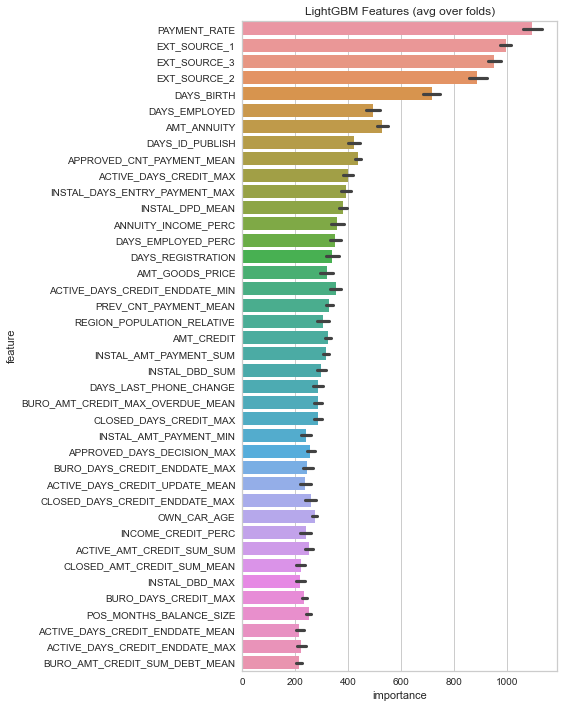

In [4]:
# Feature engineering avec kernel kaggle et première mesure de la feature importance
[df_application,
df_appli_bureau, 
df_appli_bur_prev, 
df_appli_bur_prev_pos, 
df_appli_bur_prev_pos_inst, 
df_appli_bur_prev_pos_inst_credit] = batch_preprocess_eda(False)

In [5]:
df_appli_bur_prev_pos_inst_credit.shape

(356251, 798)

In [7]:
# Suppression des données des test avec target non renseignée
df_data_train = df_appli_bur_prev_pos_inst_credit.copy()
df_train_feature = df_data_train[df_data_train.TARGET.isnull() == False]

In [8]:
df_train_feature.shape

(307507, 798)

In [9]:
df_train_feature.head(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZ

In [10]:
df_train_feature.to_csv('./Input/df_train_feature.csv', index=False)

In [11]:
df_train_feature_id = df_train_feature[['SK_ID_CURR']]

In [12]:
df_train_feature_id.shape

(307507, 1)

In [14]:
df_train_feature_id.head(3)

,SK_ID_CURR
0,100002
1,100003
2,100004


In [15]:
df_train_feature_target = df_train_feature[['TARGET']]
df_train_feature_target['TARGET'] = df_train_feature_target['TARGET'].astype('int')

In [16]:
df_train_feature_target.shape

(307507, 1)

In [17]:
df_train_feature_target.head(3)

,TARGET
0,1
1,0
2,0


In [18]:
# Suppression de la variable "SK_ID_CURR" des datasets train
df_train_feature_sans_id = df_train_feature.drop(['SK_ID_CURR'], axis = 1)

# Labels pour la classe TARGET
df_target_train = df_train_feature_sans_id.pop('TARGET')

In [19]:
df_train_feature_sans_id.head(3)

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Busines

In [20]:
df_train_feature_sans_id.shape

(307507, 796)

In [21]:
df_target_train.shape

(307507,)

In [22]:
df_target_train.head(3)

0    1.0
1    0.0
2    0.0
Name: TARGET, dtype: float64

## 5.2 Feature selection : sélection récursive par LightGBM

Dans cette section, nous essaierons davantage de réduire l'ensemble de caractéristiques, en utilisant un modèle de classification, en utilisant l'attribut d'importance des caractéristiques . Dans cette méthode, nous exécuterons de manière récursive le modèle de classification sur l'ensemble de données d'entraînement et vérifierons l'AUC de validation croisée. Si l'AUC de validation croisée descend en dessous d'un certain seuil, nous arrêterons d'ajouter les fonctionnalités les fonctionnalités.

Les étapes seraient :

- Exécutez le classificateur sur l'ensemble d'entraînement et calculez l'AUC de validation croisée 3 fois.

- Sélectionnez les caractéristiques qui ont une importance non nulle selon le modèle.

- Réexécutez le classificateur avec les fonctionnalités qui n'avaient aucune importance de fonctionnalité. Ceci est fait parce qu'il peut y avoir des cas où le classifieur aurait attribué une importance de 0 caractéristique à certaines caractéristiques, mais cela pourrait être dû à cette itération et à ce caractère aléatoire. Nous réexécutons donc le classificateur sur ces caractéristiques, pour voir si elles seules peuvent donner un bon score métrique.

- Arrêtez d'ajouter des fonctionnalités si le score de validation croisée pour les fonctionnalités de faible importance passe en dessous d'un seuil

In [23]:
#instantiating the class recursive_feature_selector
df_data_feat = df_train_feature_sans_id.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
feature_selector =  recursive_feature_selector(df_data_feat, df_target_train)
df_data_feat_select = feature_selector.main()
important_columns = feature_selector.important_columns

Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 556
	Cross Validation score = 0.7808028079616345
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	Cross Validation score = 0.6424597184538493

Done Selecting Features.
Total columns removed = 240

Initial Shape of train_data = (307507, 796)
Final Shape of train_data = (307507, 556)

Total Time Taken = 0:02:32.565989


In [24]:
important_columns

['APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ORGANIZATION_TYPE_Military',
 'INSTAL_PAYMENT_PERC_VAR',
 'PREV_NAME_YIELD_GROUP_middle_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN',
 'APPROVED_AMT_CREDIT_MEAN',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'BURO_DAYS_CREDIT_MIN',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'LIVINGAPARTMENTS_AVG',
 'POS_SK_DPD_MEAN',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR',
 'ORGANIZATION_TYPE_School',
 'OWN_CAR_AGE',
 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
 'WEEKDAY_APPR_PROCESS_START_SUNDAY',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
 'FLOORSMIN_AVG',
 'PREV_RATE_DOWN_PAYMENT_MAX',
 'BURO_STATUS_2_MEAN_MEAN',
 'PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN',
 'BURO_CREDIT_TYPE_Consumercredit_MEAN',
 'CC_AMT_RECIVABLE_MAX',
 'REFUSED_RATE_DOWN_PAYMENT_MIN',
 'NAME_TYPE_SUITE_Spousepartner',
 'PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN',
 'PREV_AMT_GOODS_PRICE_MAX'

In [27]:
df_data_feat_select.head(3)

,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,LIVINGAPARTMENTS_AVG,POS_SK_DPD_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,ORGANIZATION_TYPE_School,OWN_CAR_AGE,ACTIVE_MONTHS_BALANCE_MIN_MIN,WEEKDAY_APPR_PROCESS_START_SUNDAY,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,FLOORSMIN_AVG,PREV_RATE_DOWN_PAYMENT_MAX,BURO_STATUS_2_MEAN_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,CC_AMT_RECIVABLE_MAX,REFUSED_RATE_DOWN_PAYMENT_MIN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,BURO_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,CC_CNT_DRAWINGS_CURRENT_VAR,BURO_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_DAYS_CREDIT_MAX,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,NONLIVINGAREA_MEDI,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,CC_AMT_INST_MIN_REGULARITY_MIN,WEEKDAY_APPR_PROCESS_START_TUESDAY,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,CC_AMT_PAYMENT_CURRENT_MEAN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,APPROVED_AMT_CREDIT_MAX,BURO_MONTHS_BALANCE_MAX_MAX,CC_AMT_BALANCE_SUM,BURO_STATUS_1_MEAN_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,YEARS_BEGINEXPLUATATION_MODE,CC_SK_DPD_DEF_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,BURO_STATUS_3_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,CC_MONTHS_BALANCE_MIN,OCCUPATION_TYPE_Salesstaff,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,CC_AMT_RECIVABLE_SUM,REFUSED_HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,CC_SK_DPD_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_CLIENT_TYPE_New_MEAN,REFUSED_APP_CREDIT_PERC_MIN,CC_AMT_RECIVABLE_MIN,NAME_FAMILY_STATUS_Civilmarriage,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,ENTRANCES_AVG,REFUSED_AMT_ANNUITY_MIN,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_DRAWINGS_CURRENT_VAR,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,CC_AMT_PAYMENT_CURRENT_VAR,LANDAREA_MEDI,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APARTMENTS_AVG,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_DAYS_CREDIT_VAR,INCOME_PER_PERSON,NONLIVINGAPARTMENTS_AVG,ACTIVE_AMT_ANNUITY_MAX,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REFUSED_AMT_CREDIT_MAX,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,APARTMENTS_MEDI,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,REFUSED_APP_CREDIT_PERC_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEA

In [28]:
df_data_feat_select.shape

(307507, 556)

In [29]:
df_data_feat_select.to_csv('./Input/df_data_feat_select.csv', index=False)

## 5.3 Création de features supplémentaires

### 5.3.1 Création de la variable AGE

In [31]:
# Creation de feature supplémentaires sur df_data_feat_select
# Age du client
df_data_feat_select['AGE'] = round(df_data_feat_select['DAYS_BIRTH'] / -365).astype('int')

In [32]:
df_data_feat_select[['AGE']].head(3)

,AGE
0,26
1,46
2,52


In [33]:
# Concaténation avec l'identifiant client
df_data_feat_select_id = pd.concat([df_train_feature_id, df_data_feat_select], axis=1)

In [34]:
df_data_feat_select_id.shape

(307507, 558)

In [35]:
df_data_feat_select_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,LIVINGAPARTMENTS_AVG,POS_SK_DPD_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,ORGANIZATION_TYPE_School,OWN_CAR_AGE,ACTIVE_MONTHS_BALANCE_MIN_MIN,WEEKDAY_APPR_PROCESS_START_SUNDAY,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,FLOORSMIN_AVG,PREV_RATE_DOWN_PAYMENT_MAX,BURO_STATUS_2_MEAN_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,CC_AMT_RECIVABLE_MAX,REFUSED_RATE_DOWN_PAYMENT_MIN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,BURO_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,CC_CNT_DRAWINGS_CURRENT_VAR,BURO_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_DAYS_CREDIT_MAX,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,NONLIVINGAREA_MEDI,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,CC_AMT_INST_MIN_REGULARITY_MIN,WEEKDAY_APPR_PROCESS_START_TUESDAY,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,CC_AMT_PAYMENT_CURRENT_MEAN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,APPROVED_AMT_CREDIT_MAX,BURO_MONTHS_BALANCE_MAX_MAX,CC_AMT_BALANCE_SUM,BURO_STATUS_1_MEAN_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,YEARS_BEGINEXPLUATATION_MODE,CC_SK_DPD_DEF_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,BURO_STATUS_3_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,CC_MONTHS_BALANCE_MIN,OCCUPATION_TYPE_Salesstaff,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,CC_AMT_RECIVABLE_SUM,REFUSED_HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,CC_SK_DPD_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_CLIENT_TYPE_New_MEAN,REFUSED_APP_CREDIT_PERC_MIN,CC_AMT_RECIVABLE_MIN,NAME_FAMILY_STATUS_Civilmarriage,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,ENTRANCES_AVG,REFUSED_AMT_ANNUITY_MIN,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_DRAWINGS_CURRENT_VAR,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,CC_AMT_PAYMENT_CURRENT_VAR,LANDAREA_MEDI,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APARTMENTS_AVG,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_DAYS_CREDIT_VAR,INCOME_PER_PERSON,NONLIVINGAPARTMENTS_AVG,ACTIVE_AMT_ANNUITY_MAX,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REFUSED_AMT_CREDIT_MAX,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,APARTMENTS_MEDI,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,REFUSED_APP_CREDIT_PERC_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvi

### 5.3.2 Création de la variable PREVIOUS_APPLICATION_COUNT

In [36]:
# Creation de feature supplémentaires
# Nombre total de demandes précédentes pris par chaque client.
previous_application_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [38]:
# Fusionner cette nouvelle colonne dans notre échantillon de données
df_data_feat_select_id = df_data_feat_select_id.merge(previous_application_counts, on='SK_ID_CURR', how='left')

In [39]:
df_data_feat_select_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,LIVINGAPARTMENTS_AVG,POS_SK_DPD_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,ORGANIZATION_TYPE_School,OWN_CAR_AGE,ACTIVE_MONTHS_BALANCE_MIN_MIN,WEEKDAY_APPR_PROCESS_START_SUNDAY,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,FLOORSMIN_AVG,PREV_RATE_DOWN_PAYMENT_MAX,BURO_STATUS_2_MEAN_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,CC_AMT_RECIVABLE_MAX,REFUSED_RATE_DOWN_PAYMENT_MIN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,BURO_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,CC_CNT_DRAWINGS_CURRENT_VAR,BURO_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_DAYS_CREDIT_MAX,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,NONLIVINGAREA_MEDI,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,CC_AMT_INST_MIN_REGULARITY_MIN,WEEKDAY_APPR_PROCESS_START_TUESDAY,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,CC_AMT_PAYMENT_CURRENT_MEAN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,APPROVED_AMT_CREDIT_MAX,BURO_MONTHS_BALANCE_MAX_MAX,CC_AMT_BALANCE_SUM,BURO_STATUS_1_MEAN_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,YEARS_BEGINEXPLUATATION_MODE,CC_SK_DPD_DEF_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,BURO_STATUS_3_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,CC_MONTHS_BALANCE_MIN,OCCUPATION_TYPE_Salesstaff,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,CC_AMT_RECIVABLE_SUM,REFUSED_HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,CC_SK_DPD_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_CLIENT_TYPE_New_MEAN,REFUSED_APP_CREDIT_PERC_MIN,CC_AMT_RECIVABLE_MIN,NAME_FAMILY_STATUS_Civilmarriage,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,ENTRANCES_AVG,REFUSED_AMT_ANNUITY_MIN,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_DRAWINGS_CURRENT_VAR,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,CC_AMT_PAYMENT_CURRENT_VAR,LANDAREA_MEDI,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APARTMENTS_AVG,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_DAYS_CREDIT_VAR,INCOME_PER_PERSON,NONLIVINGAPARTMENTS_AVG,ACTIVE_AMT_ANNUITY_MAX,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REFUSED_AMT_CREDIT_MAX,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,APARTMENTS_MEDI,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,REFUSED_APP_CREDIT_PERC_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvi

In [40]:
df_data_feat_select_id.shape

(307507, 559)

### 5.3.3 Création de la variable PREVIOUS_LOANS_COUNT

In [41]:
#Number of previous applications of the clients to Home Credit
previous_loan_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [42]:
#Merge this new column in our data sample
df_data_feat_select_id = df_data_feat_select_id.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

In [43]:
df_data_feat_select_id.shape

(307507, 560)

In [44]:
df_data_feat_select_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,LIVINGAPARTMENTS_AVG,POS_SK_DPD_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,ORGANIZATION_TYPE_School,OWN_CAR_AGE,ACTIVE_MONTHS_BALANCE_MIN_MIN,WEEKDAY_APPR_PROCESS_START_SUNDAY,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,FLOORSMIN_AVG,PREV_RATE_DOWN_PAYMENT_MAX,BURO_STATUS_2_MEAN_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,CC_AMT_RECIVABLE_MAX,REFUSED_RATE_DOWN_PAYMENT_MIN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,BURO_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,CC_CNT_DRAWINGS_CURRENT_VAR,BURO_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_DAYS_CREDIT_MAX,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,NONLIVINGAREA_MEDI,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,CC_AMT_INST_MIN_REGULARITY_MIN,WEEKDAY_APPR_PROCESS_START_TUESDAY,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,CC_AMT_PAYMENT_CURRENT_MEAN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,APPROVED_AMT_CREDIT_MAX,BURO_MONTHS_BALANCE_MAX_MAX,CC_AMT_BALANCE_SUM,BURO_STATUS_1_MEAN_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,YEARS_BEGINEXPLUATATION_MODE,CC_SK_DPD_DEF_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,BURO_STATUS_3_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,CC_MONTHS_BALANCE_MIN,OCCUPATION_TYPE_Salesstaff,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,CC_AMT_RECIVABLE_SUM,REFUSED_HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,CC_SK_DPD_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_CLIENT_TYPE_New_MEAN,REFUSED_APP_CREDIT_PERC_MIN,CC_AMT_RECIVABLE_MIN,NAME_FAMILY_STATUS_Civilmarriage,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,ENTRANCES_AVG,REFUSED_AMT_ANNUITY_MIN,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_DRAWINGS_CURRENT_VAR,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,CC_AMT_PAYMENT_CURRENT_VAR,LANDAREA_MEDI,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APARTMENTS_AVG,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_DAYS_CREDIT_VAR,INCOME_PER_PERSON,NONLIVINGAPARTMENTS_AVG,ACTIVE_AMT_ANNUITY_MAX,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REFUSED_AMT_CREDIT_MAX,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,APARTMENTS_MEDI,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,REFUSED_APP_CREDIT_PERC_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvi

### 5.3.4 Ajout d'autres variables

In [45]:
# Autres ajouts de features df_train_data
#Pourcentage du montant final du crédit par rapport au revenus total
df_data_feat_select_id['CREDIT_PERCENT_INCOME'] =\
df_data_feat_select_id['AMT_CREDIT'] / df_data_feat_select_id['AMT_INCOME_TOTAL']
#Pourcentage remboursement crédit sur les revenus total
df_data_feat_select_id['ANNUITY_CREDIT_PERCENT_INCOME'] =\
df_data_feat_select_id['AMT_ANNUITY'] / df_data_feat_select_id['AMT_INCOME_TOTAL']
#DUREE DE REMBOURSEMENT DU CREDIT : PRIX TOTAL CREDIT / PRIX PAIEMENT PAR AN 
df_data_feat_select_id['CREDIT_REFUND_TIME'] =\
df_data_feat_select_id['AMT_CREDIT'] / df_data_feat_select_id['AMT_ANNUITY']
#POURCENTAGE DE JOURS TRAVAILLES
df_data_feat_select_id['DAYS_EMPLOYED_PERCENT'] =\
df_data_feat_select_id['DAYS_EMPLOYED'] / df_data_feat_select_id['DAYS_BIRTH']

In [46]:
df_data_feat_select_id.shape

(307507, 564)

In [47]:
df_data_feat_select_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,LIVINGAPARTMENTS_AVG,POS_SK_DPD_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,ORGANIZATION_TYPE_School,OWN_CAR_AGE,ACTIVE_MONTHS_BALANCE_MIN_MIN,WEEKDAY_APPR_PROCESS_START_SUNDAY,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,FLOORSMIN_AVG,PREV_RATE_DOWN_PAYMENT_MAX,BURO_STATUS_2_MEAN_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,CC_AMT_RECIVABLE_MAX,REFUSED_RATE_DOWN_PAYMENT_MIN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,BURO_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,CC_CNT_DRAWINGS_CURRENT_VAR,BURO_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_DAYS_CREDIT_MAX,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,NONLIVINGAREA_MEDI,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,CC_AMT_INST_MIN_REGULARITY_MIN,WEEKDAY_APPR_PROCESS_START_TUESDAY,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,CC_AMT_PAYMENT_CURRENT_MEAN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,APPROVED_AMT_CREDIT_MAX,BURO_MONTHS_BALANCE_MAX_MAX,CC_AMT_BALANCE_SUM,BURO_STATUS_1_MEAN_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,YEARS_BEGINEXPLUATATION_MODE,CC_SK_DPD_DEF_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,BURO_STATUS_3_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,CC_MONTHS_BALANCE_MIN,OCCUPATION_TYPE_Salesstaff,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,CC_AMT_RECIVABLE_SUM,REFUSED_HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,CC_SK_DPD_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_CLIENT_TYPE_New_MEAN,REFUSED_APP_CREDIT_PERC_MIN,CC_AMT_RECIVABLE_MIN,NAME_FAMILY_STATUS_Civilmarriage,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,ENTRANCES_AVG,REFUSED_AMT_ANNUITY_MIN,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_DRAWINGS_CURRENT_VAR,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,CC_AMT_PAYMENT_CURRENT_VAR,LANDAREA_MEDI,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APARTMENTS_AVG,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_DAYS_CREDIT_VAR,INCOME_PER_PERSON,NONLIVINGAPARTMENTS_AVG,ACTIVE_AMT_ANNUITY_MAX,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REFUSED_AMT_CREDIT_MAX,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,APARTMENTS_MEDI,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,REFUSED_APP_CREDIT_PERC_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvi

## 5.4 Traitement des valeurs manquantes

### 5.4.1 Suppression des colonnes avec au moins 20 % de valeurs NaN

In [51]:
# Suppresion des colonnes avec 20 % de valeurs NaN ou plus
df_data_feat_select_id_mod = drop_column_perc_nan(df_data_feat_select_id, 20.0)
df_data_feat_select_id_mod.shape

(307507, 334)

In [52]:
df_data_feat_select_id_mod.to_csv('./Input/df_data_feat_select_id_mod.csv', index=False)

In [53]:
df_data_feat_select_id_mod.drop(columns=['SK_ID_CURR'], inplace=True)

In [54]:
df_data_feat_select_id_mod.shape

(307507, 333)

In [55]:
df_data_feat_select_id_mod.head(3)

,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_COUNT,DAYS

### 5.4.2 Imputation des valeurs NaN par la médiane

In [56]:
# Imputation des valeurs manquantes par la médiane pour dataset df_train_data
#X = np.nan_to_num(df_train_data_feat_select_id_mod)
df_data_feat_select_id_mod.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy = 'median')
df_data_feat_select_imput = imputer.fit_transform(df_data_feat_select_id_mod)

In [58]:
train_data_mod_tr_nan = pd.DataFrame(df_data_feat_select_imput,\
                                    columns=df_data_feat_select_id_mod.columns)

In [59]:
train_data_mod_tr_nan.isna().sum().sum()

0

In [60]:
train_data_mod_tr_nan.shape

(307507, 333)

In [61]:
train_data_mod_tr_nan.head(3)

,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_COUNT,DAYS

In [62]:
train_data_mod_tr_nan.to_csv('./Input/train_data_mod_tr_nan.csv', index=False)

## 5.5 Standardisation des données

In [66]:
# Standardisation des données du dataset train_data_mod
scaler = MinMaxScaler()
train_data_mod_tr_nan_std = std_dataset(train_data_mod_tr_nan, scaler)
train_data_mod_tr_nan_std.head(5)

,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_COUNT,DAYS

In [67]:
train_data_mod_tr_nan_std.shape

(307507, 333)

In [70]:
train_data_mod_tr_nan_std.isna().sum().sum()

0

In [68]:
train_data_mod_tr_nan_std.to_csv('./Input/train_data_mod_tr_nan_std.csv', index=False)

In [80]:
df_train_feature_id.reset_index(drop=True, inplace=True)

In [81]:
df_train_feature_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SK_ID_CURR  307507 non-null  int64
dtypes: int64(1)
memory usage: 2.3 MB


In [82]:
train_data_mod_tr_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 333 entries, APPROVED_AMT_DOWN_PAYMENT_MAX to DAYS_EMPLOYED_PERCENT
dtypes: float64(333)
memory usage: 781.2 MB


## 5.6 Sauvegarde des données pour modélisation

In [83]:
# Sauvegarde des données data avec id sans standardisation
train_data_mod_tr_nan_id = pd.concat([df_train_feature_id, train_data_mod_tr_nan], axis=1)

In [84]:
train_data_mod_tr_nan_id.isna().sum().sum()

0

In [85]:
train_data_mod_tr_nan_id.shape

(307507, 334)

In [86]:
train_data_mod_tr_nan_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [88]:
# Sauvegarde du dataset final sans standardisation en csv
train_data_mod_tr_nan_id.to_csv('./Input/dataset_final/train_data_mod_tr_nan_id.csv', index=False)

In [89]:
train_data_mod_tr_nan_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 333 entries, APPROVED_AMT_DOWN_PAYMENT_MAX to DAYS_EMPLOYED_PERCENT
dtypes: float64(333)
memory usage: 781.2 MB


In [90]:
# Sauvegarde des données data avec id sans standardisation
train_data_mod_tr_nan_std_id = pd.concat([df_train_feature_id, train_data_mod_tr_nan_std], axis=1)

In [91]:
train_data_mod_tr_nan_std_id.isna().sum().sum()

0

In [92]:
train_data_mod_tr_nan_std_id.shape

(307507, 334)

In [93]:
train_data_mod_tr_nan_std_id.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [94]:
# Sauvegarde du dataset final avec standardisation en csv
train_data_mod_tr_nan_std_id.to_csv('./Input/dataset_final/train_data_mod_tr_nan_std_id.csv', index=False)

In [96]:
# Sauvegarde des id en csv
df_train_feature_id.to_csv('./Input/dataset_final/train_data_id.csv', index=False)

In [97]:
# Sauvegarde des target en csv
df_train_feature_target.to_csv('./Input/dataset_final/train_data_target.csv', index=False)

In [102]:
train_data_mod_tr_nan_id.to_csv("./Input/dataset_final/train_data_mod_tr_nan_id.zip", 
           index=False, 
           compression="zip")

In [60]:
train_data.shape

(307507, 1633)

In [61]:
test_data = create_new_features(test_data, df_previous_appli_agrege,
                    df_credit_card_agrege, df_installments_aggrege, df_bureau_agrege)

In [62]:
test_data.shape

(48744, 1632)